In [73]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, get_cycle_data)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [74]:
# def sfun(x):
#     return all([ ("Pforzheim" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
# fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = mp.search_installed_fleet_by_contains_name("Pforzheim")
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4
index,24188,24495,24473,24315,24244
Count_OpHour,2464.0,2440.0,2316.0,2256.0,2251.0
OperationalCondition,Available,Not Available,Running,Running,Available
shutdown_counter,266.0,293.0,290.0,213.0,199.0
startup_counter,235.0,249.0,263.0,208.0,196.0
id,136431,136740,136718,136558,136487
Engine Version,C101,C101,C101,C101,C101
Engine Type,920,920,920,920,920
Engine Series,9,9,9,9,9
Country,DE,DE,DE,DE,DE


In [100]:
motor = fleet.iloc[0]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('HKW Pforzheim M01', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [101]:
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)
fsm = msgFSM(e, p_from="2021-10-01", successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)

#fsm.restore()
fsm.run1(enforce=True) # run Finite State Machine
fsm.store()

FSM: 100%|███████████████████████| 69059/69059 [00:17<00:00, 4042.46 messages/s]


In [102]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 157, Successful: 134, Failed: 23 => 85.4%


In [103]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,60.42,5.26,20.29,,9.74,277.78,373.49,,,2331.62,0.51,90.24,,4,3
1,1,False,AUTO,60.45,5.25,16.06,,11.95,27.32,121.02,,,,23.04,0.0,72.25,0,0
2,2,True,AUTO,280.88,5.99,14.6,,35.17,277.78,614.42,,,950.02,0.5,90.47,,2,4
3,3,True,AUTO,60.34,5.86,18.88,,7.92,277.78,370.77,,,625.59,54.79,0.0,87.55,0,3
4,4,True,AUTO,60.38,5.24,17.97,,11.97,277.78,373.34,,,10963.58,0.51,94.22,,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,True,AUTO,60.38,5.37,16.72,,24.03,277.78,384.28,,,13284.88,79.72,0.0,89.86,0,3
153,153,True,AUTO,60.44,5.57,13.9,,39.28,277.78,396.96,,,9335.75,186.71,0.0,90.29,0,3
154,154,True,AUTO,60.42,5.14,15.05,,26.49,277.78,384.89,,,15825.76,245.17,0.0,90.7,0,2
155,155,False,AUTO,11.11,,,,,,11.11,,,,,,,0,0


In [104]:
fsm.results['starts'][0];

In [105]:
#Execute FSM Run 2
# fsm.restore()
# rda = fsm.run2(rda, silent=False)
# fsm.store()

In [106]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,157.00,146.00,5.00,142.00,142.00,0.0,0.0,157.00,138.00,142.00,139.00,121.00
mean,105.72,17.12,561.59,27.72,273.08,NaN,NaN,416.79,51011.24,104.45,444.03,90.47
std,130.23,24.35,1018.52,18.07,29.59,NaN,NaN,237.97,74756.02,61.74,5094.96,2.10
min,2.84,11.80,7.68,1.21,27.32,NaN,NaN,5.24,0.30,0.10,0.00,72.25
25%,60.36,13.75,14.10,17.64,277.78,NaN,NaN,374.30,8344.61,59.74,0.00,90.34
50%,60.42,14.31,117.28,22.30,277.78,NaN,NaN,380.57,21328.55,115.10,0.00,90.76
75%,60.47,15.36,297.40,35.76,277.78,NaN,NaN,404.08,66248.01,142.60,0.00,91.33
max,867.97,305.39,2371.49,86.46,277.78,NaN,NaN,2681.44,490656.10,245.17,60079.46,92.04


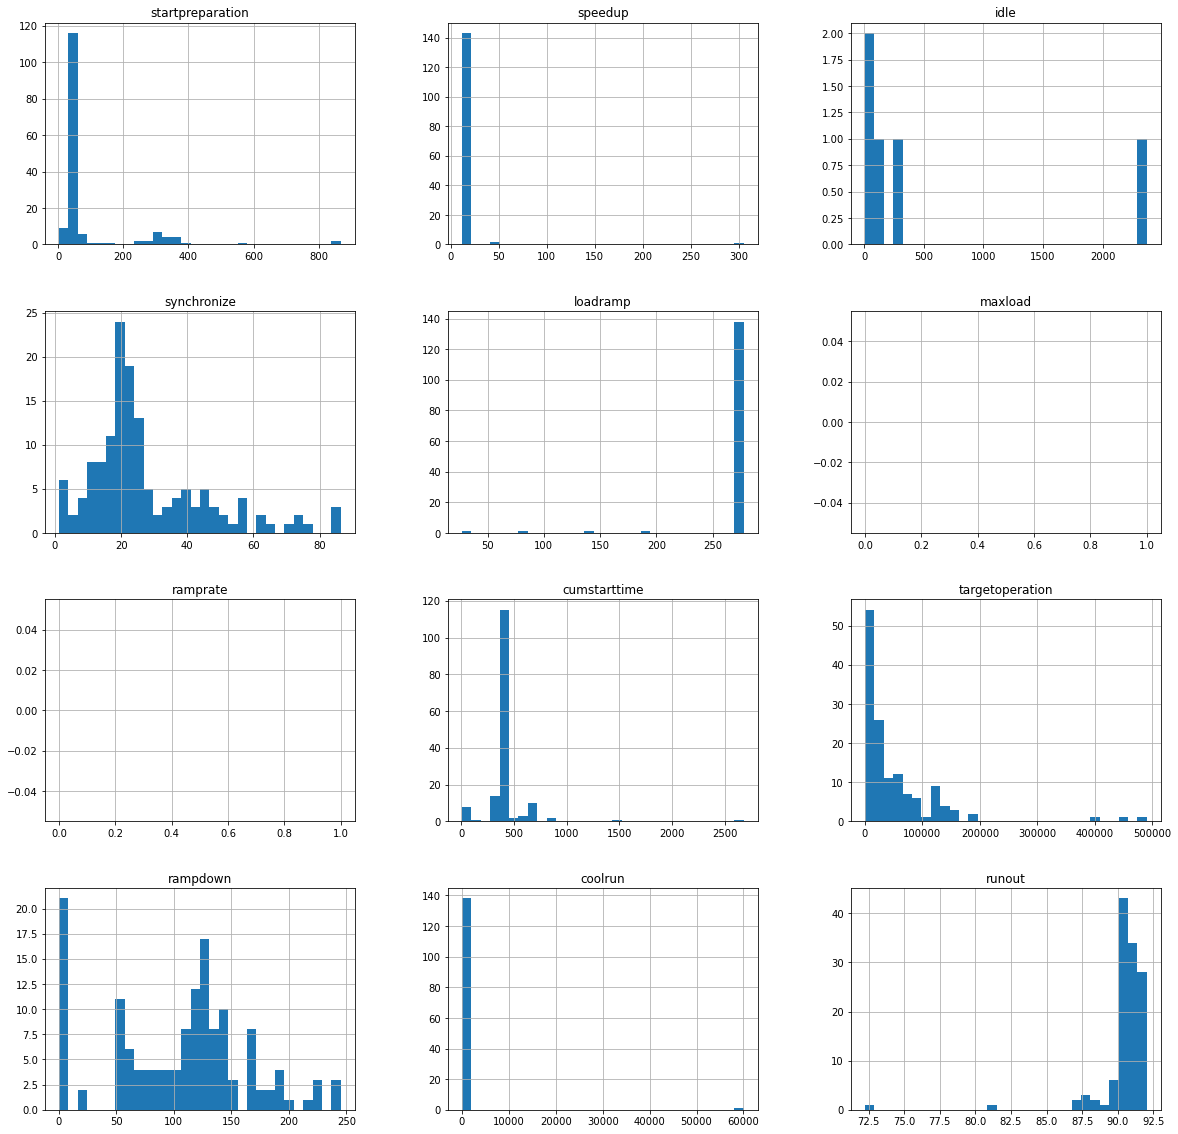

In [107]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [83]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [84]:
from dowork import plot_now
vset = ['Various_Values_SpeedAct','Power_PowerAct','Various_Values_PosTurboBypassA1','Various_Values_PosWasteGateB','Power_SetPower','Exhaust_TempCylMax','Exhaust_TempCylMin','Hyd_PressCrankCase','Hyd_PressOilDif','TecJet_Lambda1','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_SetPower'], 'ylim':(0,15000), 'color':'dodgerblue'},
    {'col':['Power_PowerAct'], 'ylim':(0,15000), 'color':'red'},
    {'col':['Various_Values_PosTurboBypassA1'], '_ylim':(0,15000), 'color':'black'},
    {'col':['Various_Values_PosWasteGateB'], '_ylim':(0,15000), 'color':'MediumVioletRed'},
    {'col':['power_diff'], '_ylim':(0,5000), 'color':'purple'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Exhaust_TempCylMax'],'ylim': [200, 700], 'color':'darkred'},
    {'col':['Exhaust_TempCylMin'],'ylim': [200, 700], 'color':'salmon'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['TecJet_Lambda1'],'_ylim': [0, 2], 'color':'green'},
    {'col':['Hyd_PressOil'],'_ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'_ylim': [0, 110], 'color':'#2171b5'}
]


In [85]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('');
rdb[filterFSM.run2filter_content]

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,60.468000,5.843000,21.623000,NaN,1.830999,277.777000,367.541999,NaN,NaN,2180.899000,0.404000,91.772,NaN,2.0,3.0
1,1,True,AUTO,60.399000,5.776999,18.052999,NaN,67.002000,277.776999,429.007997,NaN,NaN,2239.001000,120.936999,0.000,89.863000,0.0,3.0
2,2,False,AUTO,60.378000,5.751000,14.257999,NaN,21.640999,277.776999,379.804997,NaN,NaN,137.426000,0.404000,88.799,NaN,2.0,3.0
3,3,True,AUTO,60.340000,5.566999,17.156000,NaN,11.564000,277.777000,372.403999,NaN,NaN,53648.341999,138.990000,0.000,91.849999,0.0,5.0
4,4,True,AUTO,60.371999,5.667000,14.767000,NaN,20.514000,277.776999,379.096998,NaN,NaN,24890.284999,155.895000,0.000,91.770000,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147,True,AUTO,60.419000,5.153000,13.780999,NaN,42.216000,277.776999,399.345998,NaN,NaN,28556.037999,180.405000,0.000,90.992000,0.0,0.0
148,148,True,AUTO,60.427000,5.268999,13.491000,NaN,32.862999,277.777000,389.826998,NaN,NaN,26293.470000,132.993999,0.000,90.949000,0.0,3.0
149,149,True,AUTO,60.444999,5.159000,13.628000,NaN,59.092999,277.777000,416.101998,NaN,NaN,8979.395000,220.332000,0.000,90.980999,0.0,2.0
150,150,True,AUTO,60.446999,5.879000,14.398000,NaN,22.936999,277.776999,381.437997,NaN,NaN,3284.255000,146.368000,0.000,90.682000,0.0,1.0


In [88]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='70%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=151), Output()), _do…

In [91]:
inerestingstarts = [41,42,54,67,68,69,70]
startversuch = rdb.iloc[v]; 
data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)

data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
fig = plot_now(fsm, data, startversuch,vset, dset, dfigsize=(26,14))
#fsm.starts.iloc[v].to_dict()
bokeh_show(fig)

von: 23.11.2021 14:46:29 bis: 25.11.2021 04:49:08


state,severity,Number,date,message
targetoperation,800,2262,25.11.2021 04:49:07,Cylinder peak pressure maximum


state,severity,Number,date,message
targetoperation,700,3444,25.11.2021 01:58:16,Main gas train set- to actual-gas pressure deviation
targetoperation,700,3444,25.11.2021 03:15:35,Main gas train set- to actual-gas pressure deviation
targetoperation,700,2471,25.11.2021 04:29:58,PI optimization required
targetoperation,700,9216,25.11.2021 04:43:58,Port injection opening duration maximum
targetoperation,700,2470,25.11.2021 04:45:50,IMEP deviation from average value


In [45]:
fsm.starts.iloc[v].to_dict();

In [93]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

  0 * |0054| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | off | AUTO  | 600 23.11.2021 14:46:29 1231 Request module on
  1   |0055| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | on  | AUTO  | 600 23.11.2021 14:46:29 3686 Release District heating circuit operation ON
  2   |0055| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | on  | AUTO  | 600 23.11.2021 14:46:29 1282 Demand engine cooling water preheating pump off
  3   |0055| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | on  | AUTO  | 600 23.11.2021 14:46:29 1259 Demand oil pump on
  4   |0055| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | on  | AUTO  | 600 23.11.2021 14:46:29 1257 Demand engine cooling water pump on
  5   |0055| 23.11 13:14:04 standstill        | 23.11 14:46:29 startpreparation  | on  | AUTO  | 600 23.11.2021 14:46:43 3698 Exhaust boiler flap open
  6 * |0055| 23.11 14:46:29 startpreparation  | 23.1

In [94]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

c:\Users\chvatdi00\Documents\Scripts\statemachine/data/1402901/1402901_messages.txt


In [ ]:
fsm._e.BMEP

In [99]:
for v in fsm.results['runlogdetail']:
    if 'Air Injection' in v.__str__():
        if v.msg.severity > 600:
            print(v)

  |0062| 02.12 02:59:40 starter           | 02.12 02:59:46 speedup           | on  | AUTO  | 700 02.12.2021 02:59:50 9293 Direct Air Injection shut off valve failure at opening
  |0063| 04.12 15:39:33 starter           | 04.12 15:39:38 speedup           | on  | AUTO  | 700 04.12.2021 15:39:42 9293 Direct Air Injection shut off valve failure at opening
  |0064| 04.12 18:50:44 starter           | 04.12 18:50:50 speedup           | on  | AUTO  | 700 04.12.2021 18:50:53 9293 Direct Air Injection shut off valve failure at opening
  |0066| 14.12 02:00:07 starter           | 14.12 02:00:12 speedup           | on  | AUTO  | 700 14.12.2021 02:00:16 9293 Direct Air Injection shut off valve failure at opening
  |0067| 14.12 11:17:10 starter           | 14.12 11:17:15 speedup           | on  | AUTO  | 700 14.12.2021 11:17:20 9293 Direct Air Injection shut off valve failure at opening
  |0068| 16.12 02:01:24 starter           | 16.12 02:01:30 speedup           | on  | AUTO  | 700 16.12.2021 02:01:3